# k-Nearest Neighbors Model
kNN makes predictions based on its similarity to its neighbors or datapoints. We're using this model because:
* kNN is easier to implement compared to the rest of the models. We would like to see how a simpler model fares against more complex models. It can serve as a baseline.
* Our target variable has multiple categories. It may be naive but it works well for multiclass classification due to the majority vote.

It's important to note the following about kNN:
* It may struggle in highly-dimensional datasets and large datasets.
* After cleaning the dataset, there are notable imbalances according to the YData-Profiling Report. kNN may not be as accurate.

## Prerequisites

In [123]:
# necessary imports
import random
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt

# loading
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

# for model
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [124]:
# setup code taken from STINTSY class notebook
# Makes matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline

plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# autoreload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Identifying Features to Consider

First, we will consider what variables to consider. (Feature Selection)

In [125]:
numerical_vars = ['PUFC25_PBASIC', 'PUFC05_AGE', 'PUFC18_PNWHRS', 'PUFC19_PHOURS', 'PUFC28_THOURS'] # based on anova results
bincateg_vars = ['PUFC08_CURSCH', 'PUFC09_GRADTECH', 'PUFC20_PWMORE', 'PUFC22_PFWRK'] # by relevance
categ_vars = ['PUFC43_QKB', 'PUFC16_PKB', 'PUFC04_SEX', 'PUFC23_PCLASS', 'PUFURB2K10'] # by highest cramers v

# merge these into one
features = numerical_vars + bincateg_vars + categ_vars
print(features)

['PUFC25_PBASIC', 'PUFC05_AGE', 'PUFC18_PNWHRS', 'PUFC19_PHOURS', 'PUFC28_THOURS', 'PUFC08_CURSCH', 'PUFC09_GRADTECH', 'PUFC20_PWMORE', 'PUFC22_PFWRK', 'PUFC43_QKB', 'PUFC16_PKB', 'PUFC04_SEX', 'PUFC23_PCLASS', 'PUFURB2K10']


## Loading the Dataset
Then, we'll load the exported dataset into the environment.

In [126]:
# load dataset into the environment
file_dir = './cleaned_df.csv'

def load_dataset(filename):
    df = pd.read_csv('cleaned_df.csv') # read
    knn_df = df.copy() # make a copy
    return knn_df

knn_df = load_dataset(file_dir)
# knn_df.head(10)

## Encoding into Numerical Values
kNN requires numerical values for the features and target variable. We will encode the categorical variables into numerical values. This is done using the `LabelEncoder` class from the `sklearn.preprocessing` module. The `LabelEncoder` class is used to convert categorical labels into numerical values. It assigns a unique integer to each category in the dataset.

In [127]:
# knn expects everything to be in numeical format

label_encoder = LabelEncoder()
for col in bincateg_vars:
    knn_df[col] = label_encoder.fit_transform(knn_df[col])

# Encoding multiclass categorical variables
for col in categ_vars:
    knn_df[col] = label_encoder.fit_transform(knn_df[col])

features = numerical_vars + bincateg_vars + categ_vars

print(knn_df[features].values)
print(knn_df['PUFC14_PROCC'].values)

[[ 0.         49.          8.         ...  1.          4.
   0.        ]
 [ 0.         61.          4.         ...  0.          6.
   0.        ]
 [ 5.52545294 19.          8.         ...  1.          2.
   0.        ]
 ...
 [ 0.         32.          4.         ...  0.          4.
   0.        ]
 [ 0.         29.          8.         ...  1.          0.
   0.        ]
 [ 0.         18.          4.         ...  1.          4.
   0.        ]]
['Skilled Agricultural, Forestry and Fishery Workers'
 'Elementary Occupations' 'Elementary Occupations' ...
 'Skilled Agricultural, Forestry and Fishery Workers' 'Managers'
 'Managers']


## Splitting the Dataset into Training and Testing Sets
We will split the dataset into training and testing sets. The training set will be used to train the model, while the testing set will be used to evaluate its performance. We will use the `train_test_split` function from the `sklearn.model_selection` module to split the dataset. The function takes the features and target variable as input and returns the training and testing sets.

In [128]:
X = knn_df[features]
y = knn_df['PUFC14_PROCC']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
# the test size is 20% of the amount of instances

Let's select our features and our target. Let's also view the shape so that we can tell if the data was prepared correctly.

In [129]:
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)

print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (56968, 14)
Training labels shape:  (56968,)
Test data shape:  (14242, 14)
Test labels shape:  (14242,)


## Instantiating the Model and Initial Training
We will use the `KNeighborsClassifier` class from the `sklearn.neighbors` module to create the kNN model. The class takes several parameters, including the number of neighbors to consider (k) and the distance metric to use. We will set k to 5 and use the default distance metric (Euclidean distance).

In [130]:
n_neighbors = 5 # arbitrarily chosen

knn_model = KNeighborsClassifier(n_neighbors, algorithm='kd_tree', metric='euclidean')

knn_model.fit(X_train, y_train) # training the model

y_predicted = knn_model.predict(X_test)

accuracy = accuracy_score(y_test, y_predicted) # from sklearn
print(f"{round(accuracy * 100, 3)}% accuracy")

65.265% accuracy


Observations: By picking an arbitary hyperparameter k = 5, the model has an accuracy score of 65.26%. We chose kd_tree arbitrarily and used the default metric (euclidean).

### Cross Validation and Hyperparameter Tuning
Cross Validation is a technique to evaluate the performance of our kNN model. It splits the dataset into k subsets called folds, and trained on k-1 folds. This is done to reduce overfitting in the model. [Source](https://www.statology.org/complete-guide-cross-validation/)

In kNN, we have a hyperparameter k (different from k-folds) which is used to determine how many neighbors are considered. For this example, we will use Grid Search to find the optimal parameters. Grid Search has a fit and score method. [Source](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

We are working with a very large dataset, so we will also be using Principal Component Analysis (PCA) to reduce the dimensionality before putting it through the Grid Search. [Source](https://peerdh.com/blogs/programming-insights/optimizing-k-nearest-neighbors-for-large-datasets-in-scikit-learn) We're only doing this once because doing it multiple times will be very expensive and time consuming.

Here, we use StandardScaler because kNN is sensitive to the scale of the data. StandardScaler standardizes the features by removing the mean and scaling to unit variance, which is important because kNN uses distance metrics to determine the similarity between data points, and if the features are not on the same scale, it can lead to biased results.

Let's see what the feature distribution looks like before scaling.

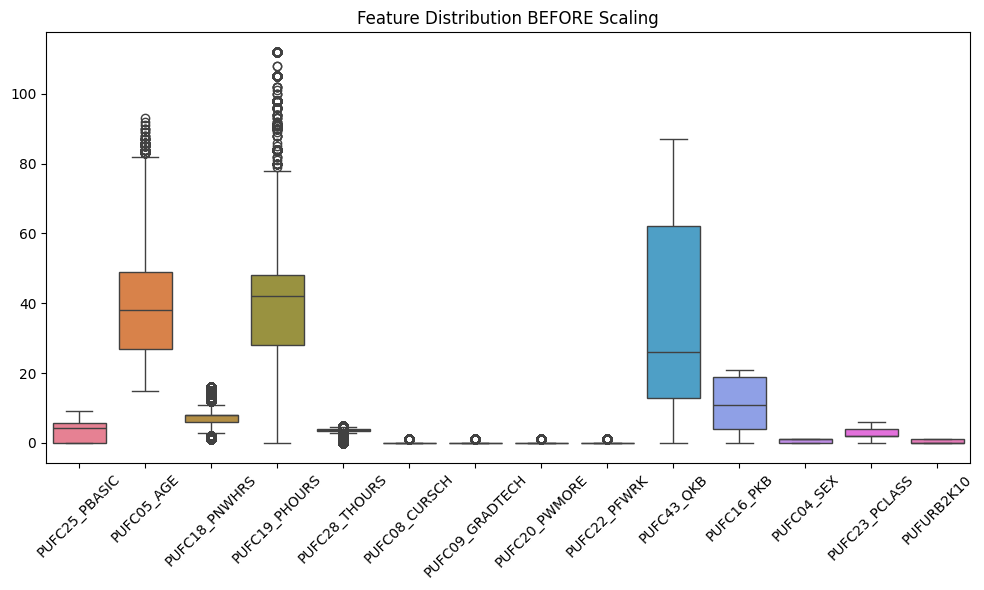

In [131]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(X_train))
plt.title('Feature Distribution BEFORE Scaling')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The boxplot looks very imbalanced. So let's use StandardScaler() and see what that looks like.

In [132]:
stdscaler = StandardScaler()
X_scaled = stdscaler.fit_transform(X_train)

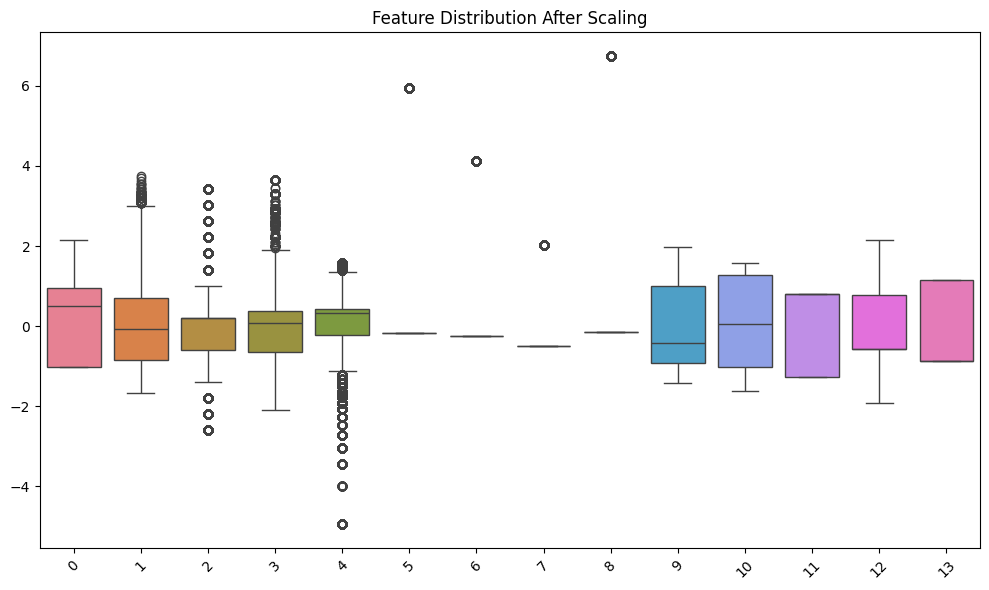

In [133]:
# before PCA after scaling
plt.figure(figsize=(10, 6))
sns.boxplot(data=pd.DataFrame(X_scaled))
plt.title('Feature Distribution After Scaling')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Observations: Many features still have outliers, but the distribution is more normal than before scaling. The features are now on the same scale, which is important for PCA and KNN.

Then we instantiate a PCA object and fit it to the training data. We will use the `fit_transform` method to transform the training data into a lower-dimensional space. The transformed data will be used to train the kNN model. We will also use the `transform` method to transform the testing data into the same lower-dimensional space.

In [134]:
pca = PCA(n_components=None)
X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
for i, var in enumerate(cumulative_variance_ratio):
    print(f"Components {i+1}: {var:.3f} variance explained")

Components 1: 0.222 variance explained
Components 2: 0.342 variance explained
Components 3: 0.443 variance explained
Components 4: 0.540 variance explained
Components 5: 0.617 variance explained
Components 6: 0.685 variance explained
Components 7: 0.748 variance explained
Components 8: 0.809 variance explained
Components 9: 0.863 variance explained
Components 10: 0.911 variance explained
Components 11: 0.943 variance explained
Components 12: 0.970 variance explained
Components 13: 0.993 variance explained
Components 14: 1.000 variance explained


Let's visualize the PCA components to see how many components we need to keep. We will plot the explained variance ratio to see how many components we need to keep.

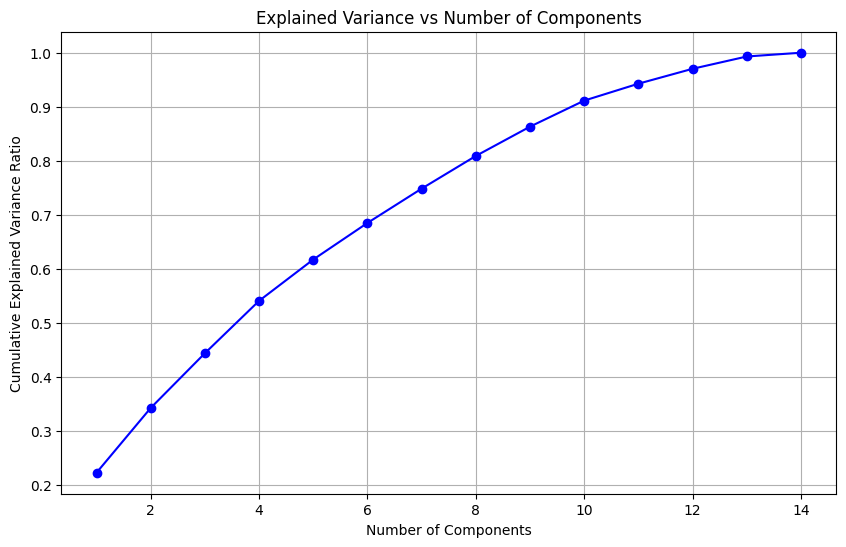

In [135]:
# after PCA
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs Number of Components')
plt.grid(True)
plt.show()

Observations: 0.90 to 0.95 is a common threshold to keep. [Source](https://medium.com/@riya190304/finding-optimal-number-of-components-in-pca-2141d2891bed) We will use 0.95 as the threshold for PCA. This means we will keep enough components to explain 95% of the variance in the data. We will use the `n_components` parameter in the PCA class to set this threshold.

In [136]:
pipeline = Pipeline([
    ('pca', PCA(n_components=0.95)), # keep 95% of variance
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [1, 3, 5, 7, 9],      # k values to try
    'knn__weights': ['uniform', 'distance'], # weighting options
    'knn__metric': ['euclidean', 'manhattan', 'chebyshev'], # distance metrics to try
    'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'] # different algorithms to try
}

grid_search = GridSearchCV(
    pipeline, 
    param_grid, 
    cv=5, # cross validation folds 
    verbose=1, # prints progress
    scoring='accuracy', # uses accuracy as a scoring metric
    n_jobs=-1 # use all the available cores
    )

grid_search.fit(X_train, y_train) # train the model

Fitting 5 folds for each of 120 candidates, totalling 600 fits


c:\Users\gicac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.5423395  0.5423395  0.53498451 0.55413564 0.53484398 0.5607885
 0.53324661 0.56303536 0.53077146 0.56577367 0.54721944 0.54721944
 0.54104057 0.55892781 0.5413038  0.56526471 0.54012767 0.56823124
 0.5371786  0.56975838 0.53668721 0.53668721 0.52801566 0.54864131
 0.52791026 0.55603142 0.52475058 0.55924373 0.52264413 0.5618592
 0.54237461 0.54237461 0.53496695 0.55417074 0.53484397 0.56078849
 0.5334046  0.56308802 0.53087679 0.56572101 0.54725455 0.54725455
 0.54119855 0.55894536 0.54140912 0.56531738 0.54030322 0.56826635
 0.53726638 0.56977594 0.53670477 0.53670477 0.52808588 0.54858865
 0.52784004 0.55606652 0.52471548 0.55922617 0.522767   0.56187676
 0.5423395  0.5423395  0.53498451 0.55413564 0.53484398 0.5607885
 0.53324661 0.56303536 0.53077146 0.56577367 0.54721944 0.54721944
 0.54104057 0.55892781 0.

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA(n_components=0.95)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__algorithm': ['auto', 'ball_tree', 'kd_tree',
                                            'brute'],
                         'knn__metric': ['euclidean', 'manhattan', 'chebyshev'],
                         'knn__n_neighbors': [1, 3, 5, 7, 9],
                         'knn__weights': ['uniform', 'distance']},
             scoring='accuracy', verbose=1)

In [137]:
print("GRID SEARCH best parameters: ", grid_search.best_params_)
print("GRID SEARCH best score: ", round(grid_search.best_score_, 3)) # prints the best score from the grid search

GRID SEARCH best parameters:  {'knn__algorithm': 'ball_tree', 'knn__metric': 'manhattan', 'knn__n_neighbors': 9, 'knn__weights': 'distance'}
GRID SEARCH best score:  0.57
